
# Innovationsprojekt - Daten aus dem "Motoren-Linearitätstest" eines Diagnostischen Instruments

Bevor ein Diagnostsiches Instrument für den Verkauf freigegeben wird, müssen diese ettliche Tests in der Produktion durchlaufen. Diese Tests stellen sicher, dass die Instrumente innerhalb ihrer definierten Spezifikationen liegen.

Im Rahmen diese Innovationsprojektes werden die Daten aus dem cobas® LIAT "Motoren Linearitätstests" analysiert. Es soll untersucht werden, ob die Konfigurationsdaten mit den Daten zur Motorenlienearität korrelieren und ob ggf. anhand der vorhanden Daten eine Voraussage gemacht werden kann, ob der Lin0-Test "Passen" oder "Failen" wird.



## cobas® LIAT (Lab In A Tube)

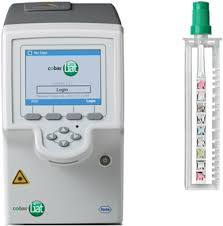

# Imports

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Daten Assessment und Datenbereinigung

### Laden des Datensets

Am Datenset wurde lediglich die Seriennummern der Instrumente annonymisiert. Sonst wurde an den Daten nichts manipuliert.

In [2]:
useTestData=False

In [3]:
if useTestData:
    df = pd.read_csv("Innovationsprojekt_Test.csv")
else:
    df = pd.read_csv("Innovationsprojekt.csv")

In [4]:
df.shape

(3801, 74)

### Es sollen alle Spalten bzw. "Features" gelistet werden

In [5]:
pd.set_option('display.max_columns', len(df.columns))

In [6]:
df.head()

,SN,C0,R0,K,B,Slope,Offset,before p0-3,before p3-4,after p0-3,after p3-4,lin0error_status,BKLSH_status,ZeroOffset_Status,Actuator,Motor #,Neg Backlash,Zero Offset,1_Close_Error Analysis 4750,2_Close_Error Analysis 4500,3_Close_Error Analysis 4250,4_Close_Error Analysis 4000,5_Close_Error Analysis 3750,6_Close_Error Analysis 3500,7_Close_Error Analysis 3250,8_Close_Error Analysis 3000,9_Close_Error Analysis 2750,10_Close_Error Analysis 2500,11_Close_Error Analysis 2250,12_Close_Error Analysis 2000,13_Close_Error Analysis 1750,14_Close_Error Analysis 1500,15_Close_Error Analysis 1250,16_Close_Error Analysis 1000,17_Close_Error Analysis 750,18_Close_Error Analysis 500,19_Close_Error Analysis 400,20_Close_Error Analysis 300,21_Close_Error Analysis 200,22_Close_Error Analysis 100,23_CloseError Analysis 0,24_Close_Error Analysis -100,25_Close_Error Analysis -200,26_Close_Error Analysis -300,27_Close_Error Analysis -400,28_Close_Error Analysis -500,29_Open_Error Analysis -400,30_Open_Error Analysis -300,31_Open_Error Analysis -200,32_Open_Error Analysis -100,33_Open_Error Analysis 0,34_Open_Error Analysis 100,35_Open_Error Analysis 200,36_Open_Error Analysis 300,37_Open_Error Analysis 400,38_Open_Error Analysis 500,39_Open_Error Analysis 750,40_Open_Error Analysis 1000,41_Open_Error Analysis 1250,42_Open_Error Analysis 1500,43_Open_Error Analysis 1750,44_Open_Error Analysis 2000,45_Open_Error Analysis 2250,46_Open_Error Analysis 2500,47_Open_Error Analysis 2750,48_Open_Error Analysis 3000,49_Open_Error Analysis 3250,50_Open_Error Analysis 3500,51_Open_Error Analysis 3750,52_Open_Error Analysis 4000,53_Open_Error Analysis 4250,54_Open_Error Analysis 4500,55_Open_Error Analysis 4750,56_Open_Error Analysis 5000
0,20024,32137.74841,21499.26250,15224.13124,4613.349738,0.749344,31678.13106,5.284028,21.329042,2.328461,3.194409,Pass,Pass,Pass,C0,1,146.349206,-13.377193,-20.158730,-11.111111,0.476190,5.396825,3.650794,1.587302,0.793651,5.079365,9.047619,8.253968,4.285714,5.714286,8.412698,11.428571,10.000000,5.714286,6.190476,-2.857143,-5.079365,-7.936508,-12.698413,0.317460,29.206349,98.095238,187.936508,281.269841,375.555556,468.571429,368.888889,273.015873,177.142857,82.222222,8.571429,-16.190476,-72.380952,-144.761905,-142.857143,-141.269841,-130.634921,-121.904762,-119.841270,-120.000000,-123.650794,-127.936508,-124.603175,-122.539682,-122.698413,-125.396825,-129.047619,-126.984127,-125.555556,-126.666667,-130.952381,-137.460318,-144.285714,-158.095238
1,20024,32450.21993,23134.84570,11266.84271,4958.987078,0.867369,31618.41704,5.569502,22.582886,2.505282,3.121790,Pass,Pass,Pass,P0,2,119.682540,-3.092183,-16.031746,-2.539683,0.793651,2.222222,3.650794,4.761905,6.825397,6.031746,4.285714,6.666667,6.507937,10.158730,9.365079,8.253968,9.682540,10.476190,13.492063,11.428571,11.746032,11.428571,11.111111,11.746032,40.317460,111.746032,209.206349,306.031746,402.222222,499.365079,395.873016,295.873016,198.095238,102.222222,30.476190,-25.079365,-91.428571,-107.301587,-114.603175,-114.920635,-106.190476,-100.000000,-106.190476,-115.873016,-116.984127,-107.619048,-105.238095,-109.523809,-119.206349,-117.142857,-111.904762,-106.666667,-109.365079,-117.777778,-115.714286,-116.825397,-121.111111,-137.142857
2,20024,31649.79002,19975.63067,17516.37026,4166.505482,0.738266,31526.85950,5.838866,18.490840,1.962564,2.661597,Pass,Pass,Pass,P1,3,136.126984,33.157060,-22.063492,-11.111111,-8.412698,-7.301587,-6.825397,-2.539683,3.333333,3.174603,0.476190,-1.587302,1.746032,6.984127,6.190476,1.587302,-0.476190,5.396825,10.634921,9.206349,6.031746,1.904762,0.634921,1.587302,56.190476,133.650794,226.666667,320.952381,416.190476,510.158730,410.158730,309.523810,208.253968,107.936508,25.079365,-23.174603,-120.000000,-128.888889,-127.301587,-125.396825,-122.063492,-130.793651,-139.841270,-136.825397,-130.952381,-127.301587,-135.714286,-142.857143,-141.111111,-132.380952,-132.539682,-139.682540,-147.142857,-147.301587,-142.380952,-146.031746,-163.968254,-180.952381

### Entfernen von Features, welche von der weiteren Betrachtung ausgeschlossen werden sollen

##### SN: 
Die Seriennummer SN und die weiteren Daten haben keinen Zusammenhang und können daher vom Datensatz enfernt werden

##### offset, before ..., after ...: 
Diese "Featurs" sollen laut Angaben des Datenerstellers nicht berücksichtig werden, da diese scheinbar keinerlei Zusammenhang mit den anderen Lin0 Testdaten haben. 

In [7]:
df= df.drop(columns=['SN', 'Offset','before p0-3','before p3-4','after p0-3','after p3-4' ])
df.head()

,C0,R0,K,B,Slope,lin0error_status,BKLSH_status,ZeroOffset_Status,Actuator,Motor #,Neg Backlash,Zero Offset,1_Close_Error Analysis 4750,2_Close_Error Analysis 4500,3_Close_Error Analysis 4250,4_Close_Error Analysis 4000,5_Close_Error Analysis 3750,6_Close_Error Analysis 3500,7_Close_Error Analysis 3250,8_Close_Error Analysis 3000,9_Close_Error Analysis 2750,10_Close_Error Analysis 2500,11_Close_Error Analysis 2250,12_Close_Error Analysis 2000,13_Close_Error Analysis 1750,14_Close_Error Analysis 1500,15_Close_Error Analysis 1250,16_Close_Error Analysis 1000,17_Close_Error Analysis 750,18_Close_Error Analysis 500,19_Close_Error Analysis 400,20_Close_Error Analysis 300,21_Close_Error Analysis 200,22_Close_Error Analysis 100,23_CloseError Analysis 0,24_Close_Error Analysis -100,25_Close_Error Analysis -200,26_Close_Error Analysis -300,27_Close_Error Analysis -400,28_Close_Error Analysis -500,29_Open_Error Analysis -400,30_Open_Error Analysis -300,31_Open_Error Analysis -200,32_Open_Error Analysis -100,33_Open_Error Analysis 0,34_Open_Error Analysis 100,35_Open_Error Analysis 200,36_Open_Error Analysis 300,37_Open_Error Analysis 400,38_Open_Error Analysis 500,39_Open_Error Analysis 750,40_Open_Error Analysis 1000,41_Open_Error Analysis 1250,42_Open_Error Analysis 1500,43_Open_Error Analysis 1750,44_Open_Error Analysis 2000,45_Open_Error Analysis 2250,46_Open_Error Analysis 2500,47_Open_Error Analysis 2750,48_Open_Error Analysis 3000,49_Open_Error Analysis 3250,50_Open_Error Analysis 3500,51_Open_Error Analysis 3750,52_Open_Error Analysis 4000,53_Open_Error Analysis 4250,54_Open_Error Analysis 4500,55_Open_Error Analysis 4750,56_Open_Error Analysis 5000
0,32137.74841,21499.26250,15224.13124,4613.349738,0.749344,Pass,Pass,Pass,C0,1,146.349206,-13.377193,-20.158730,-11.111111,0.476190,5.396825,3.650794,1.587302,0.793651,5.079365,9.047619,8.253968,4.285714,5.714286,8.412698,11.428571,10.000000,5.714286,6.190476,-2.857143,-5.079365,-7.936508,-12.698413,0.317460,29.206349,98.095238,187.936508,281.269841,375.555556,468.571429,368.888889,273.015873,177.142857,82.222222,8.571429,-16.190476,-72.380952,-144.761905,-142.857143,-141.269841,-130.634921,-121.904762,-119.841270,-120.000000,-123.650794,-127.936508,-124.603175,-122.539682,-122.698413,-125.396825,-129.047619,-126.984127,-125.555556,-126.666667,-130.952381,-137.460318,-144.285714,-158.095238
1,32450.21993,23134.84570,11266.84271,4958.987078,0.867369,Pass,Pass,Pass,P0,2,119.682540,-3.092183,-16.031746,-2.539683,0.793651,2.222222,3.650794,4.761905,6.825397,6.031746,4.285714,6.666667,6.507937,10.158730,9.365079,8.253968,9.682540,10.476190,13.492063,11.428571,11.746032,11.428571,11.111111,11.746032,40.317460,111.746032,209.206349,306.031746,402.222222,499.365079,395.873016,295.873016,198.095238,102.222222,30.476190,-25.079365,-91.428571,-107.301587,-114.603175,-114.920635,-106.190476,-100.000000,-106.190476,-115.873016,-116.984127,-107.619048,-105.238095,-109.523809,-119.206349,-117.142857,-111.904762,-106.666667,-109.365079,-117.777778,-115.714286,-116.825397,-121.111111,-137.142857
2,31649.79002,19975.63067,17516.37026,4166.505482,0.738266,Pass,Pass,Pass,P1,3,136.126984,33.157060,-22.063492,-11.111111,-8.412698,-7.301587,-6.825397,-2.539683,3.333333,3.174603,0.476190,-1.587302,1.746032,6.984127,6.190476,1.587302,-0.476190,5.396825,10.634921,9.206349,6.031746,1.904762,0.634921,1.587302,56.190476,133.650794,226.666667,320.952381,416.190476,510.158730,410.158730,309.523810,208.253968,107.936508,25.079365,-23.174603,-120.000000,-128.888889,-127.301587,-125.396825,-122.063492,-130.793651,-139.841270,-136.825397,-130.952381,-127.301587,-135.714286,-142.857143,-141.111111,-132.380952,-132.539682,-139.682540,-147.142857,-147.301587,-142.380952,-146.031746,-163.968254,-180.952381
3,32081.24823,23631.12063,13133.69606,4209.338034,0.696124,Pass,Pass,Pass,C2,4,133.333333,-16.490385,-28.095238,-9.523810,0.793651,2.222222,7.142857,6.031746,4.603175,10.793651,3.968254,6.666667,6.190476,9.841270,9.68254

### Betrachten der Datentypen mit dem wesentlichen Ziel kategorische und nominale Variablen zu identifizieren
Dazu muss in den Options die Anzahl der Zeilen so erweitert werden, dass die Datentypen für alle Spalten angezeigt werden.

In [8]:
pd.set_option('display.max_rows', len(df.columns))
df.dtypes

C0                              float64
R0                              float64
K                               float64
B                               float64
Slope                           float64
lin0error_status                 object
BKLSH_status                     object
ZeroOffset_Status                object
Actuator                         object
Motor #                           int64
Neg Backlash                    float64
Zero Offset                     float64
1_Close_Error Analysis 4750     float64
2_Close_Error Analysis 4500     float64
3_Close_Error Analysis 4250     float64
4_Close_Error Analysis 4000     float64
5_Close_Error Analysis 3750     float64
6_Close_Error Analysis 3500     float64
7_Close_Error Analysis 3250     float64
8_Close_Error Analysis 3000     float64
9_Close_Error Analysis 2750     float64
10_Close_Error Analysis 2500    float64
11_Close_Error Analysis 2250    float64
12_Close_Error Analysis 2000    float64
13_Close_Error Analysis 1750    float64


#### Die angezeigten Datentypen weissen darauf hin, dass es Potential für 4 Kategorische Features gibt:

    lin0error_status                 object
    BKLSH_status                     object
    ZeroOffset_Status                object
    Actuator                         object

#### Die Betrachtung dieser Feature lässt folgende Schlüsse zu:

    lin0error_status, BKLSH_status und ZeroOffset_Status sind kategorische Features. Diese werden wie folgt umgewandelt:
        "Pass = 1" 
        "Fail = 0"
    Die Features "Actuator" und "Motor #" sind "Dummy" Features bzw. das eine Feature lässt sich durch das andere Feature 
    zu 100% abbilden.

### Umwandeln von "lin0error_status, BKLSH_status und ZeroOffset_Status und Motor #" in kategorische Datentypen

Bemerkung: 'Motor #' wird in 'Motor_ID' umbenannt damit es mit der Funktion ....astype in eine kategorische Variable umgewandelt werden kann.

In [9]:
df.lin0error_status = df.lin0error_status.astype('category')
df.BKLSH_status = df.BKLSH_status.astype('category')
df.ZeroOffset_Status = df.ZeroOffset_Status.astype('category')
df.rename(columns={'Motor #':'Motor_ID'}, inplace = True)
df.Motor_ID = df.Motor_ID.astype('category')



### Löschen des Features "Actuator" da sich "Motor #" besser für die weitere Analyse eignet (Vector Space Model)

In [10]:
df= df.drop(columns=['Actuator' ])

In [11]:
df.head(10)

,C0,R0,K,B,Slope,lin0error_status,BKLSH_status,ZeroOffset_Status,Motor_ID,Neg Backlash,Zero Offset,1_Close_Error Analysis 4750,2_Close_Error Analysis 4500,3_Close_Error Analysis 4250,4_Close_Error Analysis 4000,5_Close_Error Analysis 3750,6_Close_Error Analysis 3500,7_Close_Error Analysis 3250,8_Close_Error Analysis 3000,9_Close_Error Analysis 2750,10_Close_Error Analysis 2500,11_Close_Error Analysis 2250,12_Close_Error Analysis 2000,13_Close_Error Analysis 1750,14_Close_Error Analysis 1500,15_Close_Error Analysis 1250,16_Close_Error Analysis 1000,17_Close_Error Analysis 750,18_Close_Error Analysis 500,19_Close_Error Analysis 400,20_Close_Error Analysis 300,21_Close_Error Analysis 200,22_Close_Error Analysis 100,23_CloseError Analysis 0,24_Close_Error Analysis -100,25_Close_Error Analysis -200,26_Close_Error Analysis -300,27_Close_Error Analysis -400,28_Close_Error Analysis -500,29_Open_Error Analysis -400,30_Open_Error Analysis -300,31_Open_Error Analysis -200,32_Open_Error Analysis -100,33_Open_Error Analysis 0,34_Open_Error Analysis 100,35_Open_Error Analysis 200,36_Open_Error Analysis 300,37_Open_Error Analysis 400,38_Open_Error Analysis 500,39_Open_Error Analysis 750,40_Open_Error Analysis 1000,41_Open_Error Analysis 1250,42_Open_Error Analysis 1500,43_Open_Error Analysis 1750,44_Open_Error Analysis 2000,45_Open_Error Analysis 2250,46_Open_Error Analysis 2500,47_Open_Error Analysis 2750,48_Open_Error Analysis 3000,49_Open_Error Analysis 3250,50_Open_Error Analysis 3500,51_Open_Error Analysis 3750,52_Open_Error Analysis 4000,53_Open_Error Analysis 4250,54_Open_Error Analysis 4500,55_Open_Error Analysis 4750,56_Open_Error Analysis 5000
0,32137.74841,21499.26250,15224.13124,4613.349738,0.749344,Pass,Pass,Pass,1,146.349206,-13.377193,-20.158730,-11.111111,0.476190,5.396825,3.650794,1.587302,0.793651,5.079365,9.047619,8.253968,4.285714,5.714286,8.412698,11.428571,10.000000,5.714286,6.190476,-2.857143,-5.079365,-7.936508,-12.698413,0.317460,29.206349,98.095238,187.936508,281.269841,375.555556,468.571429,368.888889,273.015873,177.142857,82.222222,8.571429,-16.190476,-72.380952,-144.761905,-142.857143,-141.269841,-130.634921,-121.904762,-119.841270,-120.000000,-123.650794,-127.936508,-124.603175,-122.539682,-122.698413,-125.396825,-129.047619,-126.984127,-125.555556,-126.666667,-130.952381,-137.460318,-144.285714,-158.095238
1,32450.21993,23134.84570,11266.84271,4958.987078,0.867369,Pass,Pass,Pass,2,119.682540,-3.092183,-16.031746,-2.539683,0.793651,2.222222,3.650794,4.761905,6.825397,6.031746,4.285714,6.666667,6.507937,10.158730,9.365079,8.253968,9.682540,10.476190,13.492063,11.428571,11.746032,11.428571,11.111111,11.746032,40.317460,111.746032,209.206349,306.031746,402.222222,499.365079,395.873016,295.873016,198.095238,102.222222,30.476190,-25.079365,-91.428571,-107.301587,-114.603175,-114.920635,-106.190476,-100.000000,-106.190476,-115.873016,-116.984127,-107.619048,-105.238095,-109.523809,-119.206349,-117.142857,-111.904762,-106.666667,-109.365079,-117.777778,-115.714286,-116.825397,-121.111111,-137.142857
2,31649.79002,19975.63067,17516.37026,4166.505482,0.738266,Pass,Pass,Pass,3,136.126984,33.157060,-22.063492,-11.111111,-8.412698,-7.301587,-6.825397,-2.539683,3.333333,3.174603,0.476190,-1.587302,1.746032,6.984127,6.190476,1.587302,-0.476190,5.396825,10.634921,9.206349,6.031746,1.904762,0.634921,1.587302,56.190476,133.650794,226.666667,320.952381,416.190476,510.158730,410.158730,309.523810,208.253968,107.936508,25.079365,-23.174603,-120.000000,-128.888889,-127.301587,-125.396825,-122.063492,-130.793651,-139.841270,-136.825397,-130.952381,-127.301587,-135.714286,-142.857143,-141.111111,-132.380952,-132.539682,-139.682540,-147.142857,-147.301587,-142.380952,-146.031746,-163.968254,-180.952381
3,32081.24823,23631.12063,13133.69606,4209.338034,0.696124,Pass,Pass,Pass,4,133.333333,-16.490385,-28.095238,-9.523810,0.793651,2.222222,7.142857,6.031746,4.603175,10.793651,3.968254,6.666667,6.190476,9.841270,9.682540,7.301587,9.682540,

### Kategorische Werte in Zahlenwerte transformieren 

In [12]:
def status_category_to_numeric(x):
    if x=='Pass':
        return 1
    if x=='FAIL':
        return 0

In [13]:
df['lin0error_status'] = df['lin0error_status'].apply(status_category_to_numeric)
df['BKLSH_status'] = df['BKLSH_status'].apply(status_category_to_numeric)
df['ZeroOffset_Status'] = df['ZeroOffset_Status'].apply(status_category_to_numeric)


In [14]:
df.head(n=30)

,C0,R0,K,B,Slope,lin0error_status,BKLSH_status,ZeroOffset_Status,Motor_ID,Neg Backlash,Zero Offset,1_Close_Error Analysis 4750,2_Close_Error Analysis 4500,3_Close_Error Analysis 4250,4_Close_Error Analysis 4000,5_Close_Error Analysis 3750,6_Close_Error Analysis 3500,7_Close_Error Analysis 3250,8_Close_Error Analysis 3000,9_Close_Error Analysis 2750,10_Close_Error Analysis 2500,11_Close_Error Analysis 2250,12_Close_Error Analysis 2000,13_Close_Error Analysis 1750,14_Close_Error Analysis 1500,15_Close_Error Analysis 1250,16_Close_Error Analysis 1000,17_Close_Error Analysis 750,18_Close_Error Analysis 500,19_Close_Error Analysis 400,20_Close_Error Analysis 300,21_Close_Error Analysis 200,22_Close_Error Analysis 100,23_CloseError Analysis 0,24_Close_Error Analysis -100,25_Close_Error Analysis -200,26_Close_Error Analysis -300,27_Close_Error Analysis -400,28_Close_Error Analysis -500,29_Open_Error Analysis -400,30_Open_Error Analysis -300,31_Open_Error Analysis -200,32_Open_Error Analysis -100,33_Open_Error Analysis 0,34_Open_Error Analysis 100,35_Open_Error Analysis 200,36_Open_Error Analysis 300,37_Open_Error Analysis 400,38_Open_Error Analysis 500,39_Open_Error Analysis 750,40_Open_Error Analysis 1000,41_Open_Error Analysis 1250,42_Open_Error Analysis 1500,43_Open_Error Analysis 1750,44_Open_Error Analysis 2000,45_Open_Error Analysis 2250,46_Open_Error Analysis 2500,47_Open_Error Analysis 2750,48_Open_Error Analysis 3000,49_Open_Error Analysis 3250,50_Open_Error Analysis 3500,51_Open_Error Analysis 3750,52_Open_Error Analysis 4000,53_Open_Error Analysis 4250,54_Open_Error Analysis 4500,55_Open_Error Analysis 4750,56_Open_Error Analysis 5000
0,32137.74841,21499.26250,15224.13124,4613.349738,0.749344,1,1,1,1,146.349206,-13.377193,-20.158730,-11.111111,0.476190,5.396825,3.650794,1.587302,0.793651,5.079365,9.047619,8.253968,4.285714,5.714286,8.412698,11.428571,10.000000,5.714286,6.190476,-2.857143,-5.079365,-7.936508,-12.698413,0.317460,29.206349,98.095238,187.936508,281.269841,375.555556,468.571429,368.888889,273.015873,177.142857,82.222222,8.571429,-16.190476,-72.380952,-144.761905,-142.857143,-141.269841,-130.634921,-121.904762,-119.841270,-120.000000,-123.650794,-127.936508,-124.603175,-122.539682,-122.698413,-125.396825,-129.047619,-126.984127,-125.555556,-126.666667,-130.952381,-137.460318,-144.285714,-158.095238
1,32450.21993,23134.84570,11266.84271,4958.987078,0.867369,1,1,1,2,119.682540,-3.092183,-16.031746,-2.539683,0.793651,2.222222,3.650794,4.761905,6.825397,6.031746,4.285714,6.666667,6.507937,10.158730,9.365079,8.253968,9.682540,10.476190,13.492063,11.428571,11.746032,11.428571,11.111111,11.746032,40.317460,111.746032,209.206349,306.031746,402.222222,499.365079,395.873016,295.873016,198.095238,102.222222,30.476190,-25.079365,-91.428571,-107.301587,-114.603175,-114.920635,-106.190476,-100.000000,-106.190476,-115.873016,-116.984127,-107.619048,-105.238095,-109.523809,-119.206349,-117.142857,-111.904762,-106.666667,-109.365079,-117.777778,-115.714286,-116.825397,-121.111111,-137.142857
2,31649.79002,19975.63067,17516.37026,4166.505482,0.738266,1,1,1,3,136.126984,33.157060,-22.063492,-11.111111,-8.412698,-7.301587,-6.825397,-2.539683,3.333333,3.174603,0.476190,-1.587302,1.746032,6.984127,6.190476,1.587302,-0.476190,5.396825,10.634921,9.206349,6.031746,1.904762,0.634921,1.587302,56.190476,133.650794,226.666667,320.952381,416.190476,510.158730,410.158730,309.523810,208.253968,107.936508,25.079365,-23.174603,-120.000000,-128.888889,-127.301587,-125.396825,-122.063492,-130.793651,-139.841270,-136.825397,-130.952381,-127.301587,-135.714286,-142.857143,-141.111111,-132.380952,-132.539682,-139.682540,-147.142857,-147.301587,-142.380952,-146.031746,-163.968254,-180.952381
3,32081.24823,23631.12063,13133.69606,4209.338034,0.696124,1,1,1,4,133.333333,-16.490385,-28.095238,-9.523810,0.793651,2.222222,7.142857,6.031746,4.603175,10.793651,3.968254,6.666667,6.190476,9.841270,9.682540,7.301587,9.682540,11.111111,11.587302,2.539683,-3.1746

In [15]:
df.dtypes

C0                               float64
R0                               float64
K                                float64
B                                float64
Slope                            float64
lin0error_status                category
BKLSH_status                    category
ZeroOffset_Status               category
Motor_ID                        category
Neg Backlash                     float64
Zero Offset                      float64
1_Close_Error Analysis 4750      float64
2_Close_Error Analysis 4500      float64
3_Close_Error Analysis 4250      float64
4_Close_Error Analysis 4000      float64
5_Close_Error Analysis 3750      float64
6_Close_Error Analysis 3500      float64
7_Close_Error Analysis 3250      float64
8_Close_Error Analysis 3000      float64
9_Close_Error Analysis 2750      float64
10_Close_Error Analysis 2500     float64
11_Close_Error Analysis 2250     float64
12_Close_Error Analysis 2000     float64
13_Close_Error Analysis 1750     float64
14_Close_Error A

In [16]:
df.shape

(3801, 67)

### Duplikate behandeln

#### Prüfen ob Duplikate vorhanden sind

In [17]:
df.duplicated().any()

False

Duplikate anzeigen, falls vorhanden

In [18]:
df[df.duplicated(keep=False)].head(n=10)

,C0,R0,K,B,Slope,lin0error_status,BKLSH_status,ZeroOffset_Status,Motor_ID,Neg Backlash,Zero Offset,1_Close_Error Analysis 4750,2_Close_Error Analysis 4500,3_Close_Error Analysis 4250,4_Close_Error Analysis 4000,5_Close_Error Analysis 3750,6_Close_Error Analysis 3500,7_Close_Error Analysis 3250,8_Close_Error Analysis 3000,9_Close_Error Analysis 2750,10_Close_Error Analysis 2500,11_Close_Error Analysis 2250,12_Close_Error Analysis 2000,13_Close_Error Analysis 1750,14_Close_Error Analysis 1500,15_Close_Error Analysis 1250,16_Close_Error Analysis 1000,17_Close_Error Analysis 750,18_Close_Error Analysis 500,19_Close_Error Analysis 400,20_Close_Error Analysis 300,21_Close_Error Analysis 200,22_Close_Error Analysis 100,23_CloseError Analysis 0,24_Close_Error Analysis -100,25_Close_Error Analysis -200,26_Close_Error Analysis -300,27_Close_Error Analysis -400,28_Close_Error Analysis -500,29_Open_Error Analysis -400,30_Open_Error Analysis -300,31_Open_Error Analysis -200,32_Open_Error Analysis -100,33_Open_Error Analysis 0,34_Open_Error Analysis 100,35_Open_Error Analysis 200,36_Open_Error Analysis 300,37_Open_Error Analysis 400,38_Open_Error Analysis 500,39_Open_Error Analysis 750,40_Open_Error Analysis 1000,41_Open_Error Analysis 1250,42_Open_Error Analysis 1500,43_Open_Error Analysis 1750,44_Open_Error Analysis 2000,45_Open_Error Analysis 2250,46_Open_Error Analysis 2500,47_Open_Error Analysis 2750,48_Open_Error Analysis 3000,49_Open_Error Analysis 3250,50_Open_Error Analysis 3500,51_Open_Error Analysis 3750,52_Open_Error Analysis 4000,53_Open_Error Analysis 4250,54_Open_Error Analysis 4500,55_Open_Error Analysis 4750,56_Open_Error Analysis 5000


Duplikate entfernen, falls vorhanden

In [19]:
df = df.drop_duplicates()

Grösse des Datasets nach der Bereinigung der Duplikate anzeigen

In [20]:
df.shape

(3801, 67)

### Auf Nullwerte prüfen

Prüfen ob es irgendwo Null Werte hat

In [21]:
df.isna().any().any()

False

Spalten anzeigen, welche Null Werte enthalten

In [22]:
df.columns[df.isna().any()]

Index([], dtype='object')

Zeilen mit Null Werten entfernen (alternativ könnten auch Default Werte gesetzt werden)

In [23]:
df = df.dropna(how='any', axis=0)

Grösse des Datasets nach eliminierung der Null Werte anzeigen

In [24]:
df.shape

(3801, 67)

In [25]:
df.describe()

,C0,R0,K,B,Slope,Neg Backlash,Zero Offset,1_Close_Error Analysis 4750,2_Close_Error Analysis 4500,3_Close_Error Analysis 4250,4_Close_Error Analysis 4000,5_Close_Error Analysis 3750,6_Close_Error Analysis 3500,7_Close_Error Analysis 3250,8_Close_Error Analysis 3000,9_Close_Error Analysis 2750,10_Close_Error Analysis 2500,11_Close_Error Analysis 2250,12_Close_Error Analysis 2000,13_Close_Error Analysis 1750,14_Close_Error Analysis 1500,15_Close_Error Analysis 1250,16_Close_Error Analysis 1000,17_Close_Error Analysis 750,18_Close_Error Analysis 500,19_Close_Error Analysis 400,20_Close_Error Analysis 300,21_Close_Error Analysis 200,22_Close_Error Analysis 100,23_CloseError Analysis 0,24_Close_Error Analysis -100,25_Close_Error Analysis -200,26_Close_Error Analysis -300,27_Close_Error Analysis -400,28_Close_Error Analysis -500,29_Open_Error Analysis -400,30_Open_Error Analysis -300,31_Open_Error Analysis -200,32_Open_Error Analysis -100,33_Open_Error Analysis 0,34_Open_Error Analysis 100,35_Open_Error Analysis 200,36_Open_Error Analysis 300,37_Open_Error Analysis 400,38_Open_Error Analysis 500,39_Open_Error Analysis 750,40_Open_Error Analysis 1000,41_Open_Error Analysis 1250,42_Open_Error Analysis 1500,43_Open_Error Analysis 1750,44_Open_Error Analysis 2000,45_Open_Error Analysis 2250,46_Open_Error Analysis 2500,47_Open_Error Analysis 2750,48_Open_Error Analysis 3000,49_Open_Error Analysis 3250,50_Open_Error Analysis 3500,51_Open_Error Analysis 3750,52_Open_Error Analysis 4000,53_Open_Error Analysis 4250,54_Open_Error Analysis 4500,55_Open_Error Analysis 4750,56_Open_Error Analysis 5000
count,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000,3801.000000
mean,31844.739422,21550.037699,12381.771673,4262.224440,0.765084,73.784910,-7.712168,-17.061049,-8.719928,-3.327153,-1.054109,0.640892,1.532262,0.342892,1.748746,2.670183,4.031604,4.434714,4.825714,4.972668,6.215825,6.726592,8.503527,8.469075,6.002848,5.635610,5.373941,5.207652,9.561561,37.172674,96.879685,185.774671,279.958574,374.823501,469.915770,371.218017,273.450262,176.518878,85.385634,25.954907,-17.211260,-53.020634,-56.494991,-55.331471,-54.478980,-51.972747,-51.243825,-53.117392,-53.730472,-55.289001,-56.354009,-57.097130,-57.473597,-58.838276,-60.061554,-62.314637,-61.389860,-62.267532,-64.210003,-66.863816,-73.083274,-82.001520,-97.595119
std,759.245038,2891.694303,4369.720329,1001.045415,0.087787,38.315004,33.171303,8.580496,8.798900,10.001974,10.771282,11.052823,10.981394,10.712231,10.318841,10.329732,10.121487,9.798886,9.441199,9.259614,8.953708,8.604591,8.131697,7.950943,8.254792,8.835987,9.500283,10.224564,7.974177,13.509537,27.376570,32.749315,34.151268,35.200550,36.042741,35.182974,33.907508,32.453635,26.435493,14.361586,19.444542,31.439728,38.312703,38.651032,38.353631,37.103683,36.234151,36.074679,35.920043,35.466627,35.108480,34.960591,34.934183,34.778625,34.463341,34.098838,34.088303,34.049252,33.974462,33.642996,33.392408,33.501244,34.049163
min,23896.942960,1079.420814,2356.364678,-5190.837928,0.512268,-113.206349,-169.876938,-98.253968,-146.984127,-160.158730,-171.428571,-183.650794,-185.396825,-185.238095,-189.523809,-187.460318,-182.857143,-170.952381,-158.095238,-146.190476,-132.063492,-119.523809,-100.634921,-90.952381,-87.619048,-84.761905,-76.825397,-69.523810,-56.190476

### Boxplots von den Konfiguartionsdaten

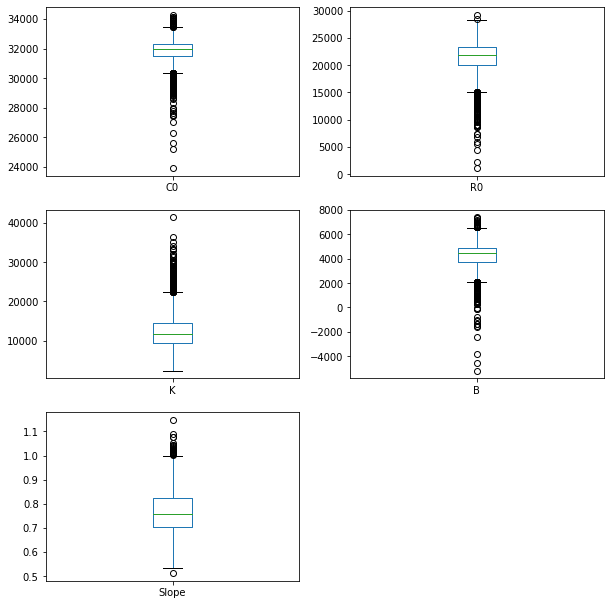

In [26]:
numerical_cols = ['C0', 'R0', 'K', 'B', 'Slope']
_ = df.loc[:, numerical_cols].plot(kind='box', subplots=True, layout=(5, 2), figsize=(10, 18), sharex=False)

Es gibt Indikation für Ausreisser-Daten. Die Daten stammen allerdings aus realen Abnahmetests. Es wir daher nachfolgend geprüft, ob es "Failed" Lin0 Tests gibt, bei denen die Konfigurationsdaten ihren Minimal- bzw. maximalwert haben.

### Korrelations Analyse

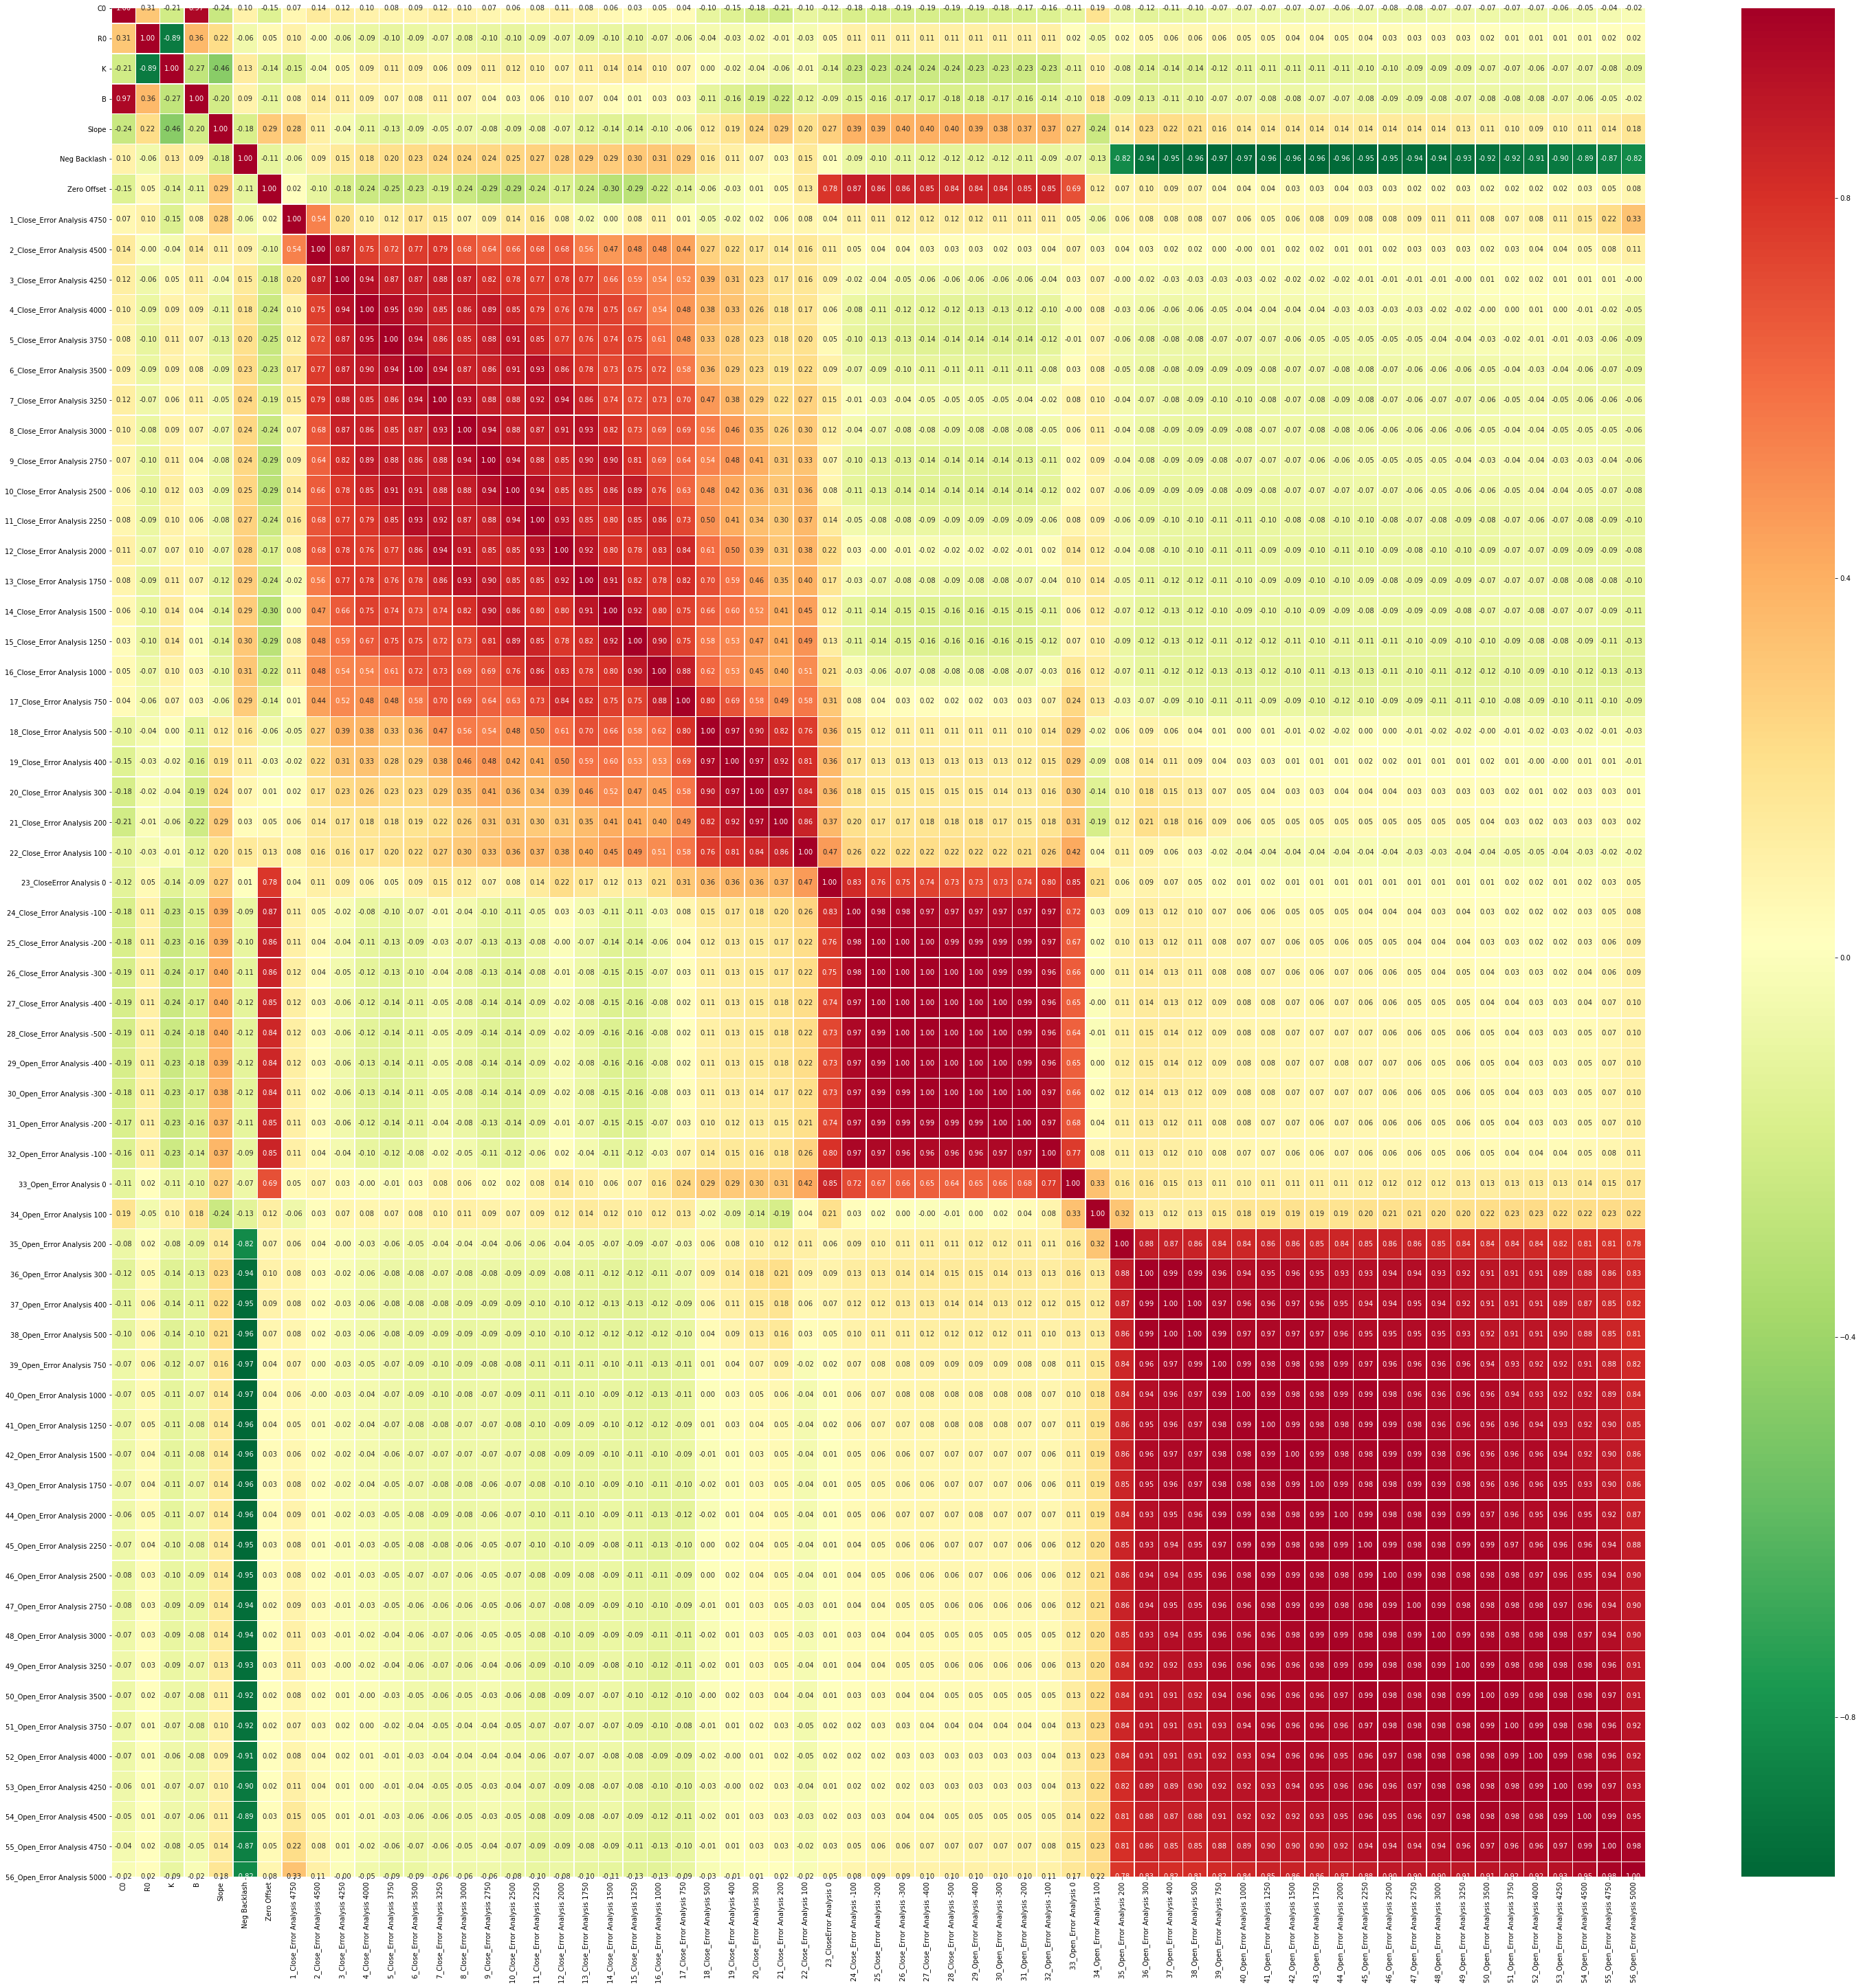

In [30]:
plt.subplots(figsize=(50, 50))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn_r', linewidths=0.5, fmt='.2f')

## Panda Profiling

Mit Panda Profiling wird ein Report erstellt. Dieser soll nur als Übersicht dienen. Dieser wird in Zukunft durch einzelne Plots ersetzt.

In [29]:
#import pandas_profiling
#profile = df.profile_report(style={'full_width':True})
# Save report
#profile.to_file(output_file="sgv-profile.html")
#profile